# Imports

In [69]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostRegressor

# Gathering Data via API

In [133]:
# Setup key and base url
key = 'IBYxHJXw2PAywxwu4L3tNsCf5cBoffL09hQYDhF8'
url_base = 'https://api.data.gov/ed/collegescorecard/v1/schools'

# Make function that will build a url given field and criteria names
def make_url(fields, criteria, page=0, per_page=20):
    crit = '&'.join(criteria) if len(criteria)>0 else ''
    field = ','.join(fields)
    url = url_base+'?api_key='+key+'&fields='+field+'&'+crit
    url += '&_page='+str(page)
    url += '&_per_page='+str(per_page)
    return url

# define the fields and critera that will go into the url request

fields = ['school.name', 
          'school.ownership', 
          'school.state_fips',
          'school.region_id',
          'school.tuition_revenue_per_fte', 
          'school.instructional_expenditure_per_fte',
          'school.faculty_salary',
          'school.ft_faculty_rate',
          '2015.admissions.admission_rate.overall',
          '2015.aid.pell_grant_rate',
          '2015.aid.federal_loan_rate',
          '2015.aid.median_debt.completers.overall',
          '2015.student.size',
          '2015.cost.attendance.academic_year',
          'program_percentage.engineering',
          'program_percentage.engineering_technology',
          'program_percentage.humanities',
          'program_percentage.biological',
          'program_percentage.mathematics',
          'program_percentage.business_marketing',
          'program.bachelors.engineering',
          'attendance.academic_year',
          'tuition.in_state',
          'tuition.out_of_state',
          '10_yrs_after_entry.mean_earnings.male_students',
          '10_yrs_after_entry.mean_earnings.female_students'
]
criteria = ['school.main_campus=1',
            'school.degrees_awarded.predominant=3',
            'school.operating=1',
            'school.online_only=0',
            'school.institutional_characteristics.level=1']

# Now get the data one page at a time
more = True
page = 0
per_page = 100
data = []

while more:
    print('Page ', page)
    url = make_url(fields, criteria, page, per_page)
    page += 1
    result = requests.get(url)
    # If the request was unsuccessful break out of the loop
    if not result.ok:
        more = False
        break
    results = result.json()
    new_data = results['results']
    data += new_data # This is where I build up the data
    meta = results['metadata']
    print(meta)
    if len(results)==0:
        print(result)
        more = False

Page  0


In [3]:
df_initial = pd.DataFrame(data)
df_initial.shape

(1818, 14)

In [4]:
df_initial.to_csv('University Data.csv', index=False)

In [5]:
df = pd.read_csv('University Data.csv')
df.head()

,2015.admissions.admission_rate.overall,2015.aid.federal_loan_rate,2015.aid.median_debt.completers.overall,2015.aid.pell_grant_rate,2015.cost.attendance.academic_year,2015.student.size,school.faculty_salary,school.ft_faculty_rate,school.instructional_expenditure_per_fte,school.name,school.ownership,school.region_id,school.state_fips,school.tuition_revenue_per_fte
0,0.6000,0.3333,NaN,0.6250,23025.0,17.0,667.0,NaN,3045,Family of Faith Christian University,2,6,40,1125
1,0.8333,0.5240,33332.0,0.4487,46040.0,1449.0,8270.0,0.3554,8939,West Coast University-Los Angeles,3,8,6,29643
2,NaN,0.3871,12830.0,0.2581,16535.0,59.0,1083.0,NaN,3077,Williamson Christian College,2,5,47,10048
3,NaN,0.0000,NaN,0.1429,19200.0,24.0,6276.0,NaN,7939,Yeshiva College of the Nations Capital,2,2,24,2416
4,0.8202,0.3798,19000.0,0.3952,23176.0,2493.0,4001.0,0.7944,7801,Bob Jones University,3,5,45,11035


In [6]:
df.isnull().sum()

2015.admissions.admission_rate.overall      264
2015.aid.federal_loan_rate                    2
2015.aid.median_debt.completers.overall     155
2015.aid.pell_grant_rate                      2
2015.cost.attendance.academic_year          102
2015.student.size                             3
school.faculty_salary                        17
school.ft_faculty_rate                       86
school.instructional_expenditure_per_fte      0
school.name                                   0
school.ownership                              0
school.region_id                              0
school.state_fips                             0
school.tuition_revenue_per_fte                0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 1 to 1816
Data columns (total 14 columns):
2015.admissions.admission_rate.overall      1450 non-null float64
2015.aid.federal_loan_rate                  1450 non-null float64
2015.aid.median_debt.completers.overall     1450 non-null float64
2015.aid.pell_grant_rate                    1450 non-null float64
2015.cost.attendance.academic_year          1450 non-null float64
2015.student.size                           1450 non-null float64
school.faculty_salary                       1450 non-null float64
school.ft_faculty_rate                      1450 non-null float64
school.instructional_expenditure_per_fte    1450 non-null int64
school.name                                 1450 non-null object
school.ownership                            1450 non-null int64
school.region_id                            1450 non-null int64
school.state_fips                           1450 non-null int64
school.tuition_revenue_per_fte              

In [9]:
sns.heatmap(df.corr())

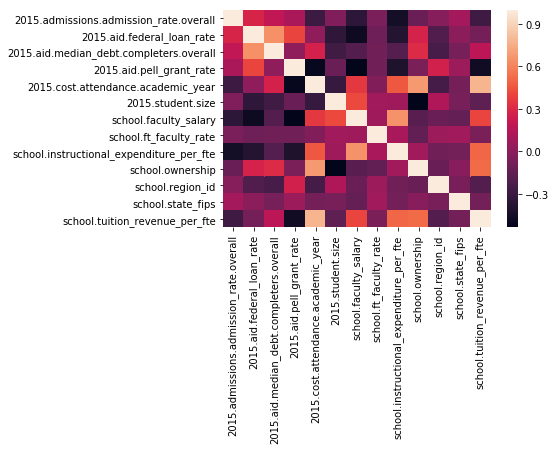

In [10]:
plt.show()

In [68]:
print(len(df.columns))
df.describe()

14


,2015.admissions.admission_rate.overall,2015.aid.federal_loan_rate,2015.aid.median_debt.completers.overall,2015.aid.pell_grant_rate,2015.cost.attendance.academic_year,2015.student.size,school.faculty_salary,school.ft_faculty_rate,school.instructional_expenditure_per_fte,school.ownership,school.region_id,school.state_fips,school.tuition_revenue_per_fte
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,0.652281,0.581724,23498.229310,0.367237,34970.655862,5464.755862,7726.335172,0.686996,10992.212414,1.673103,4.138621,30.299310,13683.441379
std,0.195403,0.174006,5058.037964,0.155715,14413.705763,7411.767814,2248.246139,0.245018,8969.912448,0.497787,2.117191,15.520598,8017.942526
min,0.050400,0.011100,1700.000000,0.067100,7312.000000,32.000000,1333.000000,0.040400,1779.000000,1.000000,0.000000,1.000000,409.000000
25%,0.531875,0.469075,21130.750000,0.254675,22045.250000,1264.250000,6214.250000,0.500000,6979.250000,1.000000,2.000000,18.000000,7987.250000
50%,0.673500,0.599700,24800.000000,0.351950,34238.500000,2345.500000,7403.500000,0.694300,8897.500000,2.000000,4.000000,31.000000,12524.500000
75%,0.788075,0.710050,27000.000000,0.455700,45766.750000,6256.500000,8837.250000,0.927225,11908.750000,2.000000,5.000000,42.000000,17485.500000
max,1.000000,0.996300,42875.000000,0.996300,67572.000000,54091.000000,21354.000000,1.000000,111600.000000,3.000000,9.000000,78.000000,147403.000000


In [22]:
X = df[[x for x in df if x != 'school.name']]
y = df['school.tuition_revenue_per_fte']

In [24]:
ss = StandardScaler()
X.head()

,2015.admissions.admission_rate.overall,2015.aid.federal_loan_rate,2015.aid.median_debt.completers.overall,2015.aid.pell_grant_rate,2015.cost.attendance.academic_year,2015.student.size,school.faculty_salary,school.ft_faculty_rate,school.instructional_expenditure_per_fte,school.ownership,school.region_id,school.state_fips,school.tuition_revenue_per_fte
1,0.8333,0.5240,33332.0,0.4487,46040.0,1449.0,8270.0,0.3554,8939,3,8,6,29643
4,0.8202,0.3798,19000.0,0.3952,23176.0,2493.0,4001.0,0.7944,7801,3,5,45,11035
9,0.6250,0.4743,15000.0,0.4963,14089.0,7225.0,5433.0,0.7143,6462,1,5,13,3049
10,0.7787,0.7836,38199.0,0.6218,32188.0,16211.0,7251.0,0.0672,5125,3,3,17,19278
11,0.9607,0.3892,16500.0,0.3551,15277.0,16048.0,5714.0,0.6969,4975,1,5,13,4649


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Filtering Number of Universities

In [ ]:
df = df[df['school.name'].str.contains("University of|State University|Harvard|Stanford|Princeton|Yale|Columbia|Brown|Dartmouth|Institute", na=False)]
df.loc[df['school.name'] == 'University of Illinois at Urbana-Champaign']

In [71]:
admission_rates = df[['2015.admissions.admission_rate.overall', 'school.name']].sort_values('2015.admissions.admission_rate.overall')
admission_rates.head(20)

,2015.admissions.admission_rate.overall,school.name
1749,0.0504,Stanford University
1067,0.0558,Harvard University
305,0.0661,Columbia University in the City of New York
120,0.0673,Yale University
1296,0.0714,Princeton University
1137,0.0830,Massachusetts Institute of Technology
1731,0.0838,University of Chicago
895,0.0881,California Institute of Technology
454,0.0949,Brown University
1516,0.1016,University of Pennsylvania


## Preprocessing

In [122]:
# Feature selection
# Chose net tuition revenue per full-time student as the target feature
# Chose all other features available, except school name as it contains a string to use as predictor features 
# in Random Forest Regressor model

X = df[[x for x in df.columns if x not in ['school.name', 'school.tuition_revenue_per_fte', '2015.cost.attendance.academic_year']]]
y = df['school.tuition_revenue_per_fte']

In [123]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [124]:
# Scaling
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Modeling - Grid Search using Random Forest Regressor as the Base Model

In [125]:
rfregr = RandomForestRegressor(warm_start=True)
rfregr_params = {'n_estimators': [50, 75, 100, 125],
                'criterion': ['mse', 'mae'],
                'max_features': ['auto', 'sqrt', 'log2', None],
                'max_depth': range(8, 11),}
rfregr_model = GridSearchCV(rfregr, rfregr_params)
rfregr_model.fit(X_train, y_train)
print('best score', rfregr_model.best_score_)
print('best params', rfregr_model.best_params_)
print('test score', rfregr_model.score(X_test, y_test))

best score 0.801690720743
best params {'criterion': 'mse', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 50}
test score 0.804644743684


In [126]:
X.columns

Index(['2015.admissions.admission_rate.overall', '2015.aid.federal_loan_rate',
       '2015.aid.median_debt.completers.overall', '2015.aid.pell_grant_rate',
       '2015.student.size', 'school.faculty_salary', 'school.ft_faculty_rate',
       'school.instructional_expenditure_per_fte', 'school.ownership',
       'school.region_id', 'school.state_fips'],
      dtype='object')

In [127]:
rfregr_solo = RandomForestRegressor(n_estimators = 75, criterion = 'mae', max_depth = 8, max_features = 'sqrt', warm_start=True)

In [128]:
rfregr_solo.fit(X_train, y_train)

print('test score', rfregr_solo.score(X_test, y_test))

test score 0.817617172067


## Finding the Features Most Indicative of a Higher Tuition Revenue

In [130]:
feature_columns = [x for x in df.columns if x not in ['school.name', 'school.tuition_revenue_per_fte', '2015.cost.attendance.academic_year']]
importance = rfregr_solo.feature_importances_
importance = pd.DataFrame(importance, index=feature_columns, 
                          columns=["Importance"])

In [131]:
# The three most important features in determining how much revenue a school brings in per year per student are control of
# institution, instructional expenditure and faculty salary
importance = importance.sort_values('Importance', ascending=False)
importance

,Importance
school.ownership,0.228183
school.instructional_expenditure_per_fte,0.166960
school.faculty_salary,0.150335
2015.aid.pell_grant_rate,0.107380
2015.student.size,0.081496
2015.aid.median_debt.completers.overall,0.067229
2015.aid.federal_loan_rate,0.049095
2015.admissions.admission_rate.overall,0.048166
school.ft_faculty_rate,0.034351
school.state_fips,0.034349


# Predicting Cost of Attendance per Academic Year

In [160]:
X = df[[x for x in df.columns if x not in ['school.name', 'school.tuition_revenue_per_fte', '2015.cost.attendance.academic_year']]]
y = df['2015.cost.attendance.academic_year']

In [161]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [162]:
# Scaling
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Gradient Boosting Regressor Model

In [147]:
# Fairly good score from Gradient Boosting Regressor model, will also try Random Forest Regressor

grdboost = GradientBoostingRegressor()
grdboost_params = {'n_estimators': [75, 100, 125, 150],
                   'max_depth': range(2, 5),
                  'max_features': ['auto', 'log2', None],
                  'min_samples_split': [2,3,4]}
grdboost_model = GridSearchCV(grdboost, grdboost_params)
grdboost_model.fit(X_train, y_train)
print('best score', grdboost_model.best_score_)
print('best params', grdboost_model.best_params_)
print('test score', grdboost_model.score(X_test, y_test))

best score 0.903963546151
best params {'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 125}
test score 0.883752067598


In [148]:
X.columns

Index(['2015.admissions.admission_rate.overall', '2015.aid.federal_loan_rate',
       '2015.aid.median_debt.completers.overall', '2015.aid.pell_grant_rate',
       '2015.student.size', 'school.faculty_salary', 'school.ft_faculty_rate',
       'school.instructional_expenditure_per_fte', 'school.ownership',
       'school.region_id', 'school.state_fips'],
      dtype='object')

## Random Forest Regressor Model

In [152]:
# The Random Forest Regressor Model seems to have done better than the Gradient Boosting Regressor Model

rfregr = RandomForestRegressor(warm_start=True)
rfregr_params = {'n_estimators': [50, 75, 100, 125],
                'criterion': ['mse', 'mae'],
                'max_features': ['auto', 'sqrt', 'log2', None],
                'max_depth': range(8, 11),}
rfregr_model = GridSearchCV(rfregr, rfregr_params)
rfregr_model.fit(X_train, y_train)
print('best score', rfregr_model.best_score_)
print('best params', rfregr_model.best_params_)
print('test score', rfregr_model.score(X_test, y_test))

best score 0.885188055008
best params {'criterion': 'mae', 'max_depth': 9, 'max_features': None, 'n_estimators': 125}
test score 0.9428243155


## Predictions from the Random Forest Regressor Model

In [170]:
rfr_predictions = rfregr_model.predict(X_test)

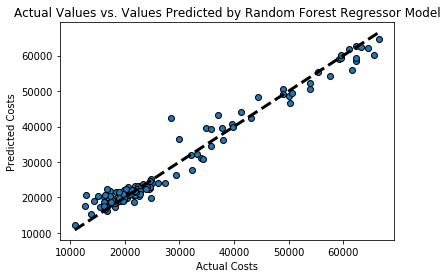

In [175]:
fig, ax = plt.subplots()
ax.scatter(y_test, rfr_predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_title('Actual Values vs. Values Predicted by Random Forest Regressor Model')
ax.set_xlabel('Actual Costs')
ax.set_ylabel('Predicted Costs')
plt.show()

The plot shows that the Random Forest Regressor did fairly well in predicting the costs of attendance, staying close to the observed costs of attendance.

## Predictions from the Gradient Boosting Model

In [179]:
gb_predictions = grdboost_model.predict(X_test)

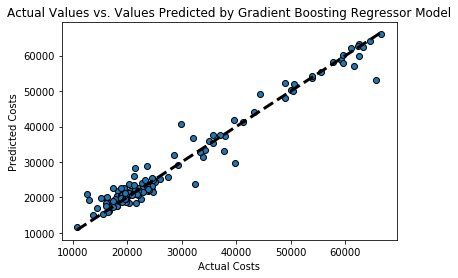

In [180]:
fig, ax = plt.subplots()
ax.scatter(y_test, gb_predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_title('Actual Values vs. Values Predicted by Gradient Boosting Regressor Model')
ax.set_xlabel('Actual Costs')
ax.set_ylabel('Predicted Costs')
plt.show()

From this plot, we can see that the Gradient Boosting Model did similarly well in its predictions of the costs of attendance.